# Instacart Basket Analysis

1. Used Data (Base Line):
    1. [https://github.com/KazukiOnodera/Instacart](https://github.com/KazukiOnodera/Instacart) 
    2. [https://www.kaggle.com/charalambos/xgb-of-instacart-ml-2-notebook](https://www.kaggle.com/charalambos/xgb-of-instacart-ml-2-notebook) → Baseline 모델로 이용
    3. [https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart/notebook](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart/notebook()) → Visaulization 및 EDA 참고
2. Problem : 
Predict which previously purchased products will be in a user’s next order.<br>
    1. 특정 고객이 가진 주문정보 만으로는 그 수가 적어 제대로 된 예측을 할 수 없다. ( 약 15개의 주문정보 뿐) 전체 고객의 확률분포를 가지고 특정 고객의 확률분포를 이용하는 것은 문제가 많아(고객의 특성을 반영하지 못함). 이를 해결하고자, 표본집단이 얼마나 모집단을 잘 대표하는지 대표성을 구하고자 하였습니다. 따라서, 어떤 고객의 특성을 잘 대변하는 집단으로 묶어서 그 집단의 확률을 구한다면 좀 더 잘 대표하지 않을까 생각하였습니다.
    2. 결국 특정 손님이 이 물건을 미래 구매 여부를 예측하는 문제다. 이를 추론하기 위해선 이 손님이 정보를 알고 있는 손님과 얼마나 유사하게 제품을 구매 하는 지를 이용하여 → 특정 집단에 속하는 고객이라면 다음 물품은 어떤 것을 구매할 확률이 높다고 가설을 세웠습니다.
    
3. Model : XGBoost, Catboost, Logistic Regression, Random Forest
4. Score  <br>
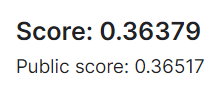

5. Feature selection : 

In [ ]:
# | 0     | category       | variable                              | Formula&Feature                                                                                                                                                                        |
# |-------|----------------|---------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
# | 1     | user           | Times_Bought_N                        | dataset.groupby(['user_id', 'product_id'])[['order_id']].count()<br/>유저가 산 특정 상품의 총 주문 횟수                                                                                              |
# | 2     | user           | total_orders                          | dataset.groupby('user_id')['order_number'].max()<br/>유저별 총 주문 횟수                                                                                                                       |
# | 3     | user x product | uxp_reorder_ratio                     | dataset.Times_Bought_N / dataset.total_orders-dataset.first_order_number+1<br/>유저가 첫주문 이후 특정 상품을 재주문 할 확률                                                                              |
# | 4     | user           | u_reordered                           | dataset.groupby(['user_id'])['reordered'].aggregate('mean')<br/>유저가 재주문할 확률                                                                                                            |
# | 5     | product        | product_total_purchases               | dataset.groupby('product_id')['order_id'].count()<br/>상품이 총 팔린 횟수                                                                                                                      |
# | 6     | product        | p_reorder_ratio                       | dataset.groupby('product_id')['reordered'].mean()<br/>상품별 재주문될 평균 확률                                                                                                                   |
# | 7     | -              | eval_set                              | 평가 set                                                                                                                                                                                 |
# | 8     | -              | order_id                              | 주문 id                                                                                                                                                                                  |
# | 9     | time           | order_hour_of_day                     | 상품 구매한 시각                                                                                                                                                                              |
# | 10    | time           | order_dow                             | 상품을 주문한 요일 (기본 데이터셋)                                                                                                                                                                   |
# | 11    | product        | aisle_id                              | aisle id                                                                                                                                                                               |
# | 12    | product        | department_id                         | department_id                                                                                                                                                                          |
# | 13    | product        | mean_position                         | dataset.groupby('product_id')['add_to_cart_order'].mean().reset_index(name = 'mean_position')<br/>상품이 카트에 추가 되는 순서 평균                                                                  |
# | 14    | product        | dept_rodrder_rate                     | dataset.groupby('department')['reordered'].mean()<br/>품목별 재주문 확률                                                                                                                       |
# | 15    | product        | aisle_reorder_reate                   | dataset.groupby('aisle')['reordered'].mean() <br/>aisle재주문 확률                                                                                                                          |
# | 16    | product        | dow_reordered                         | dataset.groupby('order_dow')['reordered'].mean() <br/>요일 별 재주문 확률                                                                                                                      |
# | 17    | product        | dow_aisle_reordered                   | dataset.groupby(['order_dow', 'aisle_id'])['reordered'].mean()<br/>요일에 따른 ailsle 재주문 확률                                                                                                |
# | 18    | product        | dow_dept_reordered                    | dataset.groupby(['departmet_id', 'aisle_id'])['reordered'].mean() <br/>요일에 따른 품목 재주문 확률                                                                                                |
# | 19    | product        | dept_percentage                       | dataset['department_id'].value_counts().to_frame('dept_percentage').reset_index()<br/>dept_percentage['dept_percentage']/sum(dept_percentage['dept_percentage'])<br/>품목별 주문확률          |
# | 20    | time           | dow_hour_rorder                       | dataset.groupby(['order_dow', 'order_hour_of_day'])['reordered'].mean()<br/>요일과 시간에 따른 재주문 확률                                                                                          |
# | 21    | prodct         | product_roredered_dow                 | dataset.groupby(['product_id','order_dow'])["reordered"].mean()<br/>요일별 특정 상품의 재주문 확률                                                                                                  |
# | 22    | product        | prod_rordered_hod                     | dataset.groupby(['product_id','order_hour_of_day'])["reordered"].mean()<br/> 시간별 특정 상품의 재주문 확률                                                                                         |
# | 23    | time           | day_reorder_rate                      | df = prior_data.groupby(['product_id','order_dow'])["product_id"].size()<br/>df = df/prior_data.groupby(["product_id"]).size() #특정 상품의 총 주문량<br/>요일별 특정 상품 주문량/ 특정 상품 총 주문량            |
# | 24    | time           | hour_reorder_rate                     |  df = prior_data.groupby(['product_id','order_hour_of_day'])["reordered"].size()<br/> df = df/prior_data.groupby(["product_id"]).size()<br/>시간별 특정 상품 주문량/특정 상품 총 주문량                  |
# | 25    | time           | p_days_since_prior_order_reorder_rate | df = prior_data.groupby(['product_id','days_since_prior_order'])["reordered"].size()<br/>df = df/prior_data.groupby(["product_id"]).size()<br/>상품별 다음 재주문시 걸리는 날짜의 확률                  |
# | 26    | time           | days_since_prior_order                | 주문 이후 재주문 하는 일수                                                                                                                                                                        |
# | 27    | time           | days_since_prior_reorder_rate         | df = prior_data.groupby(["user_id","product_id","days_since_prior_order"])["reordered"].size()<br/>df = df/prior_data.groupby(["user_id","product_id"]).size()<br/>특정 상품을 주문후 재주문하는 확률 |
# | 28    | product        | uxp_mean_position                     | dataset.groupby(["user_id","product_id"])['add_to_cart_order'].mean()<br/>고객이 카트에 추가하는 상품의 평균 순서                                                                                       |
# | 29~31 | product        | p_reduced_feat_1~3                    | product_name 에서 높은 빈도를 나타낸 단어로 8개의 그룹을 만든후 NMF로 차원 축소를 하여 변수 3개 생성<br/>많은 구매를한 상품군                                                                                                     |
# | 32    | time x user    | hod_user_reorder                      | "hod_user_reorder = all_join.groupby(['order_hour_of_day','user_id'])['reordered'].agg('sum').reset_index() <br>temp1= all_join.groupby('user_id').agg({'reordered':'sum'}).reset_index()<br>temp1.columns=['user_id','total'] <br> hod_user_reorder = hod_user_reorder.merge(temp1,on='user_id') <br>hod_user_reorder['user_hour_ratio'] = hod_user_reorder.reordered/hod_user_reorder.total"                                                                                                                                                                                                                                                                                                                    |
# | 33    | time x user    | hod_product_reorder                   | "hod_product_reorder = all_join.groupby(['order_hour_of_day','product_id'])['reordered'].agg('sum').reset_index() <br> temp1= all_join.groupby('product_id').agg({'reordered':'sum'}).reset_index() <br> temp1.columns=['product_id','total']  <br> hod_product_reorder = hod_product_reorder.merge(temp1,on='product_id') <br> hod_product_reorder['user_hour_ratio'] = hod_product_reorder.reordered/hod_product_reorder.total"                                                                                                                                                                                                                                                                                                             |
# | 34    | time x user    | product_dow_reorder                   | product_dow_reorder = all_join.groupby(['order_dow','product_id'])['reordered'].agg('sum').reset_index()<br/>temp1= all_join.groupby('product_id').agg({'reordered':'sum'}).reset_index() # reorder만<br/>temp1.columns=['product_id','total']<br/>product_dow_reorder = product_dow_reorder.merge(temp1,on='product_id')<br/>product_dow_reorder['product_day_ratio'] = product_dow_reorder.reordered/product_dow_reorder.total |
# | 35    | time x user    | user_dow_reordered                    | user_dow_reordered = all_join.groupby(['order_dow','user_id'])['reordered'].agg('sum').reset_index()<br/>temp1= all_join.groupby('user_id').agg({'reordered':'sum'}).reset_index()<br/>temp1.columns=['user_id','total']<br/>user_dow_reordered = user_dow_reordered.merge(temp1,on='user_id')<br/>user_dow_reordered['user_day_ratio'] = user_dow_reordered.reordered/user_dow_reordered.total                                 |
# | 36    | user x product | product_avg_peruser                   | all_join.groupby(['user_id','product_id'])['add_to_cart_order'].mean().to_frame('avg_add_to_cart_pos')<br/># 유저가 구매한 상품을 카트에 추가하는 평균순서<br/>                                                                                                                                                                                                                                                                                     |
# | 37    | product        | order_size_avg                        | order_size = all_join.groupby(['user_id', 'order_id'])[['product_id']].count()<br/>order_size.columns = ['size'] <br/>order_size_avg = order_size.groupby('user_id')['size'].mean().to_frame('order_size_avg').reset_index()                                                                                                                                                                                                    |
# | 38    | user x product | order_size_avg                        | "order_size = all_join.groupby(['user_id', 'order_id'])[['product_id']].count()<br>order_size.columns = ['size'] <br>order_size_avg = order_size.groupby('user_id')[['size']].mean()"                                                                                                                                                                                                                                                                                                                                                  |
# | 39    | y              | reordered                             | 재구매     

In [42]:
#Importing useful libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sys
import os
color = sns.color_palette()
%matplotlib inline
# Garbage Collector to free up memory
import gc                         
gc.enable()

## Insta Cart Toy Project
- EDA
- Visulaization
- Analysis
- Train & Vailate
- Result

In [5]:
# Data load
aisles = pd.read_csv('/home/jovyan/nas/1_user/hjlee@agilesoda.ai/Instacart/data_set/aisles.csv')
departments = pd.read_csv('/home/jovyan/nas/1_user/hjlee@agilesoda.ai/Instacart/data_set/departments.csv')
order_prod_prior = pd.read_csv('/home/jovyan/nas/1_user/hjlee@agilesoda.ai/Instacart/data_set/order_products__prior.csv')

order_prod_train = pd.read_csv('/home/jovyan/nas/1_user/hjlee@agilesoda.ai/Instacart/data_set/order_products__train.csv')
orders = pd.read_csv('/home/jovyan/nas/1_user/hjlee@agilesoda.ai/Instacart/data_set/orders.csv')
products = pd.read_csv('/home/jovyan/nas/1_user/hjlee@agilesoda.ai/Instacart/data_set/products.csv')

In [180]:
order_prod_train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


## 1. EDA

In [11]:
# aisles.describe()
# order_prod_prior.describe()
# orders.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06
mean,1.710542e+06,1.029782e+05,1.715486e+01,2.776219e+00,1.345202e+01,1.111484e+01
std,9.875817e+05,5.953372e+04,1.773316e+01,2.046829e+00,4.226088e+00,9.206737e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710542e+06,1.026890e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


In [181]:
# make main dataset pripr
all_join = orders.merge(order_prod_prior, how = 'right', on ='order_id')
all_join = pd.merge(left = all_join, right = products , how = 'left', on ='product_id')
all_join = pd.merge(left = all_join, right = aisles , how = 'left', on ='aisle_id')
all_join = pd.merge(left = all_join, right = departments , how = 'left', on ='department_id')

In [182]:
# user reorder rate
user = all_join.groupby(['user_id'])['reordered'].mean().to_frame('u_reordered')

In [183]:
# Most purchased products
products_purchased = all_join.groupby('product_id')['order_id'].count().to_frame('product_total_purchases')

# For individual marketing which product did user buy
times = all_join.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
times.head()

Times_Bought_N
user_id product_id                
1       196                     10
        10258                    9
        10326                    1
        12427                   10
        13032                    3

In [184]:
# user's total orders: order_number's max
total_orders = all_join.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders

,total_orders
user_id,
1,10
2,14
3,12
4,5
5,4
...,...
206205,3
206206,67
206207,16


In [185]:
# To find when users ordered their products at the first time (at this point because of goupby func row 30million ->13million)
first_order_no = all_join.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number').reset_index()
first_order_no

,user_id,product_id,first_order_number
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2
...,...,...,...
13307948,206209,43961,4
13307949,206209,44325,7
13307950,206209,48370,11
13307951,206209,48697,7


In [186]:
# mean ratio of the _total
p_reorder = all_join.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder

,p_reorder_ratio
product_id,
1,0.613391
2,0.133333
3,0.732852
4,0.446809
5,0.600000
...,...
49684,0.111111
49685,0.122449
49686,0.700000


In [187]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
span

,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,1,10,196,1,10
1,1,10,10258,2,9
2,1,10,10326,5,6
3,1,10,12427,1,10
4,1,10,13032,2,9
...,...,...,...,...,...
13307948,206209,13,43961,4,10
13307949,206209,13,44325,7,7
13307950,206209,13,48370,11,3
13307951,206209,13,48697,7,7


In [188]:
# user_id, product_id로 groupby한 times가 기초
uxp_ratio = pd.merge(times, span, on = ['user_id', 'product_id'], how='left')
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio = uxp_ratio.drop(['first_order_number', 'Order_Range_D'], axis = 1)
uxp_ratio

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio
0,1,196,10,10,1.000000
1,1,10258,9,10,1.000000
2,1,10326,1,10,0.166667
3,1,12427,10,10,1.000000
4,1,13032,3,10,0.333333
...,...,...,...,...,...
13307948,206209,43961,3,13,0.300000
13307949,206209,44325,1,13,0.142857
13307950,206209,48370,1,13,0.333333
13307951,206209,48697,1,13,0.142857


In [189]:
# merge
data = uxp_ratio.merge(user, on = 'user_id', how = 'left')
data = data.merge(products_purchased, on = 'product_id', how = 'left')
data = data.merge(p_reorder, on = 'product_id', how = 'left')
display(data)

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio
0,1,196,10,10,1.000000,0.694915,35791,0.776480
1,1,10258,9,10,1.000000,0.694915,1946,0.713772
2,1,10326,1,10,0.166667,0.694915,5526,0.652009
3,1,12427,10,10,1.000000,0.694915,6476,0.740735
4,1,13032,3,10,0.333333,0.694915,3751,0.657158
...,...,...,...,...,...,...,...,...
13307948,206209,43961,3,13,0.300000,0.472868,55371,0.630583
13307949,206209,44325,1,13,0.142857,0.472868,3485,0.401148
13307950,206209,48370,1,13,0.333333,0.472868,3934,0.699288
13307951,206209,48697,1,13,0.142857,0.472868,9783,0.357661


### 날짜 데이터를 사용하기 위한 작업 (prior에서 만든 시간 변수들을 사용가능 하게 만듬)

In [190]:
# orders의 train과 test 만 추출 (prior 데이터 셋에서는 파생 변수 생성을 위해 사용)
# user_id 모두 가지고있다.
orders_future = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]
display(orders_future)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,train,11,4,8,14.0
25,1492625,2,train,15,1,11,30.0
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
49,2196797,5,train,5,0,11,6.0
...,...,...,...,...,...,...,...
3420933,1716008,206205,train,4,1,16,10.0
3421001,1043943,206206,test,68,0,20,0.0
3421018,2821651,206207,test,17,2,13,14.0
3421068,803273,206208,test,50,5,11,4.0


In [191]:
# 유저가 평균적으로 주문하는 상품 개수
order_size = all_join.groupby(['user_id', 'order_id'])[['product_id']].count()
order_size.columns = ['size'] 
order_size_avg = order_size.groupby('user_id')['size'].mean().to_frame('order_size_avg').reset_index()
del order_size

In [197]:
# 유저가 한번만 샀던 상품
one_shot_pur = data[data.Times_Bought_N == 1].groupby('product_id')[['Times_Bought_N']].count().reset_index()
all_shot_pur = data.groupby('product_id')[['user_id']].count().reset_index()
one_shot_pur['one_shot_pur'] = one_shot_pur['Times_Bought_N']/all_shot_pur['user_id']
one_shot_pur = one_shot_pur.drop('Times_Bought_N', axis = 1)
one_shot_pur

,product_id,one_shot_pur
0,1,0.614525
1,2,0.897436
2,3,0.513514
3,4,0.648352
4,5,0.333333
...,...,...
49582,49684,0.875000
49583,49685,0.860465
49584,49686,0.555556
49585,49687,0.428571


In [193]:
# merge
data = data.merge(order_size_avg, on = 'user_id', how = 'left')
data = data.merge(one_shot_pur, on = ['product_id'], how = 'right')
data = data.merge(orders_future, on = ['user_id'], how = 'right')
data = data.drop('order_number', axis = 1)

# products data merge
data = data.merge(products[['product_id', 'aisle_id', 'department_id']], on = 'product_id')
data

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,order_size_avg,one_shot_pur,order_id,eval_set,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id
0,1,196,10,10,1.000000,0.694915,35791,0.77648,5.900000,0.417500,1187899,train,4,8,14.0,77,7
1,15,196,5,22,0.625000,0.819444,35791,0.77648,3.272727,0.417500,2161313,test,1,9,7.0,77,7
2,19,196,3,9,0.375000,0.348039,35791,0.77648,22.666667,0.417500,1735923,test,6,17,8.0,77,7
3,21,196,1,33,0.041667,0.502439,35791,0.77648,6.212121,0.417500,1854765,train,1,12,28.0,77,7
4,31,196,2,20,0.181818,0.364548,35791,0.77648,14.950000,0.417500,280888,test,4,9,18.0,77,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307757,200351,15408,1,11,0.142857,0.363636,2,0.00000,5.000000,0.142857,1768329,train,4,11,22.0,20,11
13307758,205587,15408,1,10,0.100000,0.568182,2,0.00000,13.200000,0.142857,2444330,train,4,16,30.0,20,11
13307759,200463,8682,1,4,0.333333,0.184211,2,0.00000,9.500000,0.064516,1427614,test,3,12,30.0,114,17
13307760,203389,8682,1,17,0.500000,0.427136,2,0.00000,11.705882,0.064516,300189,train,3,8,7.0,114,17


In [199]:
# 상품이 카트에 추가 되는 순서 평균
mean_position = all_join.groupby('product_id')['add_to_cart_order'].mean().reset_index(name = 'mean_position')

#Get aisle reorder rate
aisle_reorder_rate = all_join.groupby(['aisle_id'])['reordered'].mean().reset_index(name = 'aisle_reorder_rate') 

#Get dept reorder rate
dept_reorder_rate = all_join.groupby(['department_id'])['reordered'].mean().reset_index(name = 'dept_reorder_rate')

# 유저가 구매한 상품을 카트에 추가하는 평균순서
product_avg_peruser = all_join.groupby(['user_id','product_id'])['add_to_cart_order'].mean().to_frame('avg_add_to_cart_pos')

In [200]:
# merge
data = data.merge(mean_position, on = ['product_id'], how = 'left')
data = data.merge(dept_reorder_rate, on = ['department_id'], how = 'left')
data = data.merge(aisle_reorder_rate, on = ['aisle_id'], how = 'left')
data = data.merge(product_avg_peruser, on = ['user_id','product_id'], how = 'left')

In [201]:
display(data[data['eval_set']=='test'])
data.isnull().sum()

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,order_size_avg,one_shot_pur,...,eval_set,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id,mean_position,dept_reorder_rate,aisle_reorder_rate,avg_add_to_cart_pos
1,15,196,5,22,0.625000,0.819444,35791,0.77648,3.272727,0.417500,...,test,1,9,7.0,77,7,3.721774,0.653460,0.638832,2.200000
2,19,196,3,9,0.375000,0.348039,35791,0.77648,22.666667,0.417500,...,test,6,17,8.0,77,7,3.721774,0.653460,0.638832,6.333333
4,31,196,2,20,0.181818,0.364548,35791,0.77648,14.950000,0.417500,...,test,4,9,18.0,77,7,3.721774,0.653460,0.638832,15.500000
10,98,196,7,14,0.583333,0.460000,35791,0.77648,3.571429,0.417500,...,test,6,15,30.0,77,7,3.721774,0.653460,0.638832,2.571429
16,290,196,2,51,0.046512,0.655346,35791,0.77648,31.176471,0.417500,...,test,6,11,7.0,77,7,3.721774,0.653460,0.638832,12.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307749,193840,19259,1,7,0.200000,0.634146,1,0.00000,11.714286,0.111111,...,test,0,14,12.0,9,9,10.000000,0.461076,0.478953,10.000000
13307750,194078,40747,1,18,0.066667,0.497512,2,0.00000,11.166667,0.057143,...,test,4,10,15.0,20,11,21.000000,0.321129,0.321354,29.000000
13307752,194639,45378,1,46,0.045455,0.592827,1,0.00000,10.304348,0.066667,...,test,4,13,10.0,22,11,10.000000,0.321129,0.245838,10.000000
13307754,196359,48343,1,10,0.111111,0.469136,1,0.00000,8.100000,0.001706,...,test,1,16,28.0,27,5,6.000000,0.569924,0.565304,6.000000


user_id                    0
product_id                 0
Times_Bought_N             0
total_orders               0
uxp_reorder_ratio          0
u_reordered                0
product_total_purchases    0
p_reorder_ratio            0
order_size_avg             0
one_shot_pur               0
order_id                   0
eval_set                   0
order_dow                  0
order_hour_of_day          0
days_since_prior_order     0
aisle_id                   0
department_id              0
mean_position              0
dept_reorder_rate          0
aisle_reorder_rate         0
avg_add_to_cart_pos        0
dtype: int64

In [202]:
# dept별 분포 
dept_percentage = all_join['department_id'].value_counts().to_frame('dept_percentage').reset_index()
dept_percentage['dept_percentage']= dept_percentage['dept_percentage']/sum(dept_percentage['dept_percentage'])
dept_percentage = dept_percentage.rename(columns = {'index': 'department_id'})

# Average position of product in the cart on orders placed by user
uxp_mean_position = all_join.groupby(["user_id", "product_id"])['add_to_cart_order'].mean().reset_index(name = 'uxp_mean_position')

In [203]:
# merge
data = data.merge(dept_percentage, on = ['department_id'], how ='left')
data = data.merge(uxp_mean_position, on = ['user_id', 'product_id'], how = 'left')
data.head()

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,order_size_avg,one_shot_pur,...,order_hour_of_day,days_since_prior_order,aisle_id,department_id,mean_position,dept_reorder_rate,aisle_reorder_rate,avg_add_to_cart_pos,dept_percentage,uxp_mean_position
0,1,196,10,10,1.000000,0.694915,35791,0.77648,5.900000,0.4175,...,8,14.0,77,7,3.721774,0.65346,0.638832,1.400000,0.08294,1.400000
1,15,196,5,22,0.625000,0.819444,35791,0.77648,3.272727,0.4175,...,9,7.0,77,7,3.721774,0.65346,0.638832,2.200000,0.08294,2.200000
2,19,196,3,9,0.375000,0.348039,35791,0.77648,22.666667,0.4175,...,17,8.0,77,7,3.721774,0.65346,0.638832,6.333333,0.08294,6.333333
3,21,196,1,33,0.041667,0.502439,35791,0.77648,6.212121,0.4175,...,12,28.0,77,7,3.721774,0.65346,0.638832,2.000000,0.08294,2.000000
4,31,196,2,20,0.181818,0.364548,35791,0.77648,14.950000,0.4175,...,9,18.0,77,7,3.721774,0.65346,0.638832,15.500000,0.08294,15.500000


## 시간 데이터

In [204]:
# 1.
# 유저가 어떤 요일 어떤 물건을 살 확률 
dow_reordered = all_join.groupby(['order_dow'])['reordered'].mean().to_frame('dow_reordered')

# 요일별 aisle에서 재 판매되는 확률
dow_aisle_reordered = all_join.groupby(['order_dow', 'aisle_id'])['reordered'].mean().to_frame('dow_aisle_rordered').reset_index()

# 요일별 dept에서 재 판매되는 확률
dow_dept_reordered = all_join.groupby(['order_dow', 'department_id'])['reordered'].mean().to_frame('dow_dept_rordered').reset_index()

# 요일별 재 구매 시간 평균
dow_hour_reorder = all_join.groupby(['order_dow', 'order_hour_of_day'])['reordered'].aggregate('mean').to_frame('dow_hour_reorder').reset_index()

# 각 상품의 요일별 재구매 확귤 
prod_reordered_dow = all_join.groupby(['product_id','order_dow'])["reordered"].mean().to_frame('product_reordered_dow')

# 각 상품의 시간별 재구매 확률
prod_reordered_hod = all_join.groupby(['product_id','order_hour_of_day'])["reordered"].mean().to_frame('prod_reordered_hod')

# 각 상품에 따른 재주문 확률 
prod_reordered_dpo = all_join.groupby(['product_id','days_since_prior_order'])["reordered"].size()
prod_reordered_dpo = prod_reordered_dpo/all_join.groupby(["product_id"]).size()
prod_reordered_dpo = prod_reordered_dpo.reset_index(name = 'prod_reordered_dpo')

In [205]:
# 1.
# merge time variables
data = data.merge(dow_reordered, on = ['order_dow'], how = 'left')
data = data.merge(dow_aisle_reordered, on = ['order_dow', 'aisle_id'], how = 'left')
data = data.merge(dow_dept_reordered, on = ['order_dow', 'department_id'], how = 'left')
data = data.merge(dow_hour_reorder, on = ['order_dow', 'order_hour_of_day'], how = 'left')
data = data.merge(prod_reordered_dow, on = ['product_id', 'order_dow'], how = 'left')
data = data.merge(prod_reordered_hod, on = ['product_id', 'order_hour_of_day'], how = 'left')
data = data.merge(prod_reordered_dpo, on = ['product_id','days_since_prior_order'], how = 'left')

display(data[data['eval_set']=='test'][['user_id', 'product_id', 'order_dow', 'product_reordered_dow']])

,user_id,product_id,order_dow,product_reordered_dow
1,15,196,1,0.818099
2,19,196,6,0.671563
4,31,196,4,0.768907
10,98,196,6,0.671563
16,290,196,6,0.671563
...,...,...,...,...
13307749,193840,19259,0,0.000000
13307750,194078,40747,4,NaN
13307752,194639,45378,4,NaN
13307754,196359,48343,1,0.000000


In [207]:
data[data['eval_set']=='test'].isnull().sum()

user_id                        0
product_id                     0
Times_Bought_N                 0
total_orders                   0
uxp_reorder_ratio              0
u_reordered                    0
product_total_purchases        0
p_reorder_ratio                0
order_size_avg                 0
one_shot_pur                   0
order_id                       0
eval_set                       0
order_dow                      0
order_hour_of_day              0
days_since_prior_order         0
aisle_id                       0
department_id                  0
mean_position                  0
dept_reorder_rate              0
aisle_reorder_rate             0
avg_add_to_cart_pos            0
dept_percentage                0
uxp_mean_position              0
dow_reordered                  0
dow_aisle_rordered             0
dow_dept_rordered              0
dow_hour_reorder               0
product_reordered_dow       8538
prod_reordered_hod         41208
prod_reordered_dpo         64620
dtype: int

In [115]:
# 결측치를 해당 열의 평균으로 바꿔줌
# 1300만개중 8000~6만여개의 nan 값이므로 큰 차이가 없을 것이라 판단
data['product_reordered_dow'] = data['product_reordered_dow'].fillna(data['product_reordered_dow'].mean())
data['prod_reordered_dpo'] = data['prod_reordered_dpo'].fillna(data['product_reordered_dow'].mean())
data['prod_reordered_hod'] = data['prod_reordered_hod'].fillna(data['prod_reordered_hod'].mean())
data

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,order_size_avg,one_shot_pur,...,avg_add_to_cart_pos,dept_percentage,uxp_mean_position,dow_rordered,dow_aisle_rordered,dow_dept_rordered,dow_hour_reorder,product_reordered_dow,prod_reordered_hod,prod_reordered_dpo
0,1,196.0,10,11,0.909091,0.694915,35791,0.77648,5.363636,0.417500,...,1.400000,0.082940,1.400000,0.590979,0.632788,0.650271,0.623302,0.768907,0.800937,0.038725
1,15,196.0,5,23,0.555556,0.819444,35791,0.77648,3.130435,0.417500,...,2.200000,0.082940,2.200000,0.603843,0.677328,0.677451,0.651143,0.818099,0.808148,0.116789
2,19,196.0,3,10,0.333333,0.348039,35791,0.77648,20.400000,0.417500,...,6.333333,0.082940,6.333333,0.574369,0.600030,0.630054,0.551696,0.671563,0.749708,0.053282
3,21,196.0,1,34,0.040000,0.502439,35791,0.77648,6.029412,0.417500,...,2.000000,0.082940,2.000000,0.603843,0.677328,0.677451,0.592784,0.818099,0.769180,0.010952
4,31,196.0,2,21,0.166667,0.364548,35791,0.77648,14.238095,0.417500,...,15.500000,0.082940,15.500000,0.590979,0.632788,0.650271,0.608692,0.768907,0.808148,0.012769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307757,200351,15408.0,1,12,0.125000,0.363636,2,0.00000,4.583333,0.142857,...,2.000000,0.013785,2.000000,0.590979,0.326294,0.322719,0.586937,0.533933,0.000000,0.533933
13307758,205587,15408.0,1,11,0.090909,0.568182,2,0.00000,12.000000,0.142857,...,6.000000,0.013785,6.000000,0.590979,0.326294,0.322719,0.584787,0.533933,0.535403,0.533933
13307759,200463,8682.0,1,5,0.250000,0.184211,2,0.00000,7.600000,0.064516,...,11.000000,0.022774,11.000000,0.586272,0.289160,0.400492,0.576301,0.533933,0.535403,0.500000
13307760,203389,8682.0,1,18,0.333333,0.427136,2,0.00000,11.055556,0.064516,...,7.000000,0.022774,7.000000,0.586272,0.289160,0.400492,0.621007,0.533933,0.535403,0.533933


In [208]:
# 2.
# 요일별 특정 상품주문/특정 상품 총 주문
def product_day(prior_data = None):
    """
    feature: how frequently product was reordered on any given day ?
    """
    df = prior_data.groupby(['product_id','order_dow'])["product_id"].size()# 요일별 특정 상품의 총 주문량
    df = df/prior_data.groupby(["product_id"]).size() #특정 상품의 총 주문량
    df = df.reset_index(name = 'day_reorder_rate')
    return df

# 시간별 특정 상품 주문/특정 상품 총 주문
def product_time(prior_data = None):
    """
    feature : how frequently product was reordered on any given hour ?
    """
    df = prior_data.groupby(['product_id','order_hour_of_day'])["reordered"].size()
    df = df/prior_data.groupby(["product_id"]).size()
    df = df.reset_index(name = 'hour_reorder_rate')
    return df

# 상품별 다음 재주문시 걸리는 날짜의 확률
def product_days_since_prior(prior_data = None):
    """
    feature: how frequently a product was reordered  given that 
            difference between 2 orders containing product in days ?
    """
    df = prior_data.groupby(['product_id','days_since_prior_order'])["reordered"].size()
    df = df/prior_data.groupby(["product_id"]).size()
    df = df.reset_index(name = 'p_days_since_prior_order_reorder_rate')
    return df

# 유저가 주문한 상품의 재주문시 걸리는 날짜의 확률
def u_p_days_since_prior(prior_data = None):
    """
    feature: how frequently user reordered a particular product given difference between 2 orders in days ?
    """
    df = prior_data.groupby(["user_id","product_id","days_since_prior_order"])["reordered"].size()
    df = df/prior_data.groupby(["user_id","product_id"]).size()
    df = df.reset_index(name = 'days_since_prior_reorder_rate')
    return df

day_reorder_rate = product_day(all_join)
hour_reorder_rate = product_time(all_join)
p_days_since_prior_order_reorder_rate = product_days_since_prior(all_join)
days_since_prior_reorder_rate = u_p_days_since_prior(all_join)

In [209]:
# 2.
# merge
data = data.merge(day_reorder_rate, on = ['order_dow', 'product_id'], how = 'left')
data = data.merge(hour_reorder_rate, on = ['product_id','order_hour_of_day'], how = 'left') 
data = data.merge(p_days_since_prior_order_reorder_rate, on = ['product_id','days_since_prior_order'], how = 'left')
data = data.merge(days_since_prior_reorder_rate, on = ["user_id","product_id","days_since_prior_order"], how = 'left')
data

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,order_size_avg,one_shot_pur,...,dow_aisle_rordered,dow_dept_rordered,dow_hour_reorder,product_reordered_dow,prod_reordered_hod,prod_reordered_dpo,day_reorder_rate,hour_reorder_rate,p_days_since_prior_order_reorder_rate,days_since_prior_reorder_rate
0,1,196,10,10,1.000000,0.694915,35791,0.77648,5.900000,0.417500,...,0.632788,0.650271,0.623302,0.768907,0.800937,0.038725,0.152580,0.059652,0.038725,0.100000
1,15,196,5,22,0.625000,0.819444,35791,0.77648,3.272727,0.417500,...,0.677328,0.677451,0.651143,0.818099,0.808148,0.116789,0.214272,0.113157,0.116789,0.600000
2,19,196,3,9,0.375000,0.348039,35791,0.77648,22.666667,0.417500,...,0.600030,0.630054,0.551696,0.671563,0.749708,0.053282,0.068481,0.047777,0.053282,0.333333
3,21,196,1,33,0.041667,0.502439,35791,0.77648,6.212121,0.417500,...,0.677328,0.677451,0.592784,0.818099,0.769180,0.010952,0.214272,0.085217,0.010952,NaN
4,31,196,2,20,0.181818,0.364548,35791,0.77648,14.950000,0.417500,...,0.632788,0.650271,0.608692,0.768907,0.808148,0.012769,0.152580,0.113157,0.012769,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307757,200351,15408,1,11,0.142857,0.363636,2,0.00000,5.000000,0.142857,...,0.326294,0.322719,0.586937,NaN,0.000000,NaN,NaN,0.500000,NaN,NaN
13307758,205587,15408,1,10,0.100000,0.568182,2,0.00000,13.200000,0.142857,...,0.326294,0.322719,0.584787,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13307759,200463,8682,1,4,0.333333,0.184211,2,0.00000,9.500000,0.064516,...,0.289160,0.400492,0.576301,NaN,NaN,0.500000,NaN,NaN,0.500000,1.000000
13307760,203389,8682,1,17,0.500000,0.427136,2,0.00000,11.705882,0.064516,...,0.289160,0.400492,0.621007,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [210]:
data.isnull().sum()

user_id                                         0
product_id                                      0
Times_Bought_N                                  0
total_orders                                    0
uxp_reorder_ratio                               0
u_reordered                                     0
product_total_purchases                         0
p_reorder_ratio                                 0
order_size_avg                                  0
one_shot_pur                                    0
order_id                                        0
eval_set                                        0
order_dow                                       0
order_hour_of_day                               0
days_since_prior_order                          0
aisle_id                                        0
department_id                                   0
mean_position                                   0
dept_reorder_rate                               0
aisle_reorder_rate                              0


In [211]:
# 열 평균으로 결측치 채우기
data['day_reorder_rate'] = data['day_reorder_rate'].fillna(data['day_reorder_rate'].mean())
data['hour_reorder_rate'] = data['hour_reorder_rate'].fillna(data['hour_reorder_rate'].mean())
data['p_days_since_prior_order_reorder_rate'] = data['p_days_since_prior_order_reorder_rate'].fillna(data['p_days_since_prior_order_reorder_rate'].mean())

# 1300만개 데이터중 1000만개가 nan이므로 삭제
data = data.drop(['days_since_prior_reorder_rate'], axis = 1)

In [212]:
# 3.
## hod_user_reorder(주문 시간에 따른 유저가 상풍믈 재주문율)
def hod_user_reordered_func(df):
    hod_user_reordered = df.groupby(['order_hour_of_day','user_id'])['reordered'].agg('sum').reset_index()
    temp1= df.groupby('user_id').agg({'reordered':'sum'}).reset_index()
    temp1.columns=['user_id','total']
    hod_user_reordered = hod_user_reordered.merge(temp1, on='user_id')
    hod_user_reordered['hod_user_reordered'] = hod_user_reordered.reordered/hod_user_reordered.total
    del temp1
    hod_user_reordered = hod_user_reordered.drop(['reordered','total'],axis = 1)
    hod_user_reordered.head()
    return hod_user_reordered
    

## dow_user_reordered ratio (요일에 따른 유저의 재 주문율) 
def dow_user_reordered_func(df):
    dow_user_reordered = df.groupby(['order_dow','user_id'])['reordered'].agg('sum').reset_index()
    temp1= df.groupby('user_id').agg({'reordered':'sum'}).reset_index()
    temp1.columns=['user_id','total']
    dow_user_reordered = dow_user_reordered.merge(temp1,on = 'user_id')
    dow_user_reordered['dow_user_reordered'] = dow_user_reordered.reordered/dow_user_reordered.total
    del temp1
    dow_user_reordered = dow_user_reordered.drop(['reordered','total'],axis = 1)
    dow_user_reordered.head()
    return dow_user_reordered


## hod_product_reorder(주문 시간에 따른 상풍이 재주문율)
def hod_product_reordered_func(df):
    hod_product_reordered = df.groupby(['order_hour_of_day','product_id'])['reordered'].agg('sum').reset_index()
    temp1= df.groupby('product_id').agg({'reordered':'sum'}).reset_index()
    temp1.columns=['product_id','total']
    hod_product_reordered = hod_product_reordered.merge(temp1,on='product_id')
    hod_product_reordered['hod_product_reordered'] = hod_product_reordered.reordered/hod_product_reordered.total
    del temp1
    hod_product_reordered = hod_product_reordered.drop(['reordered','total'],axis=1)
    hod_product_reordered.head()
    return hod_product_reordered


## product_dow_reorder(주문 요일에 따른 유저가 상품이 재주문율)
def product_dow_reordered_func(df):
    product_dow_reordered = all_join.groupby(['order_dow','product_id'])['reordered'].agg('sum').reset_index()
    temp1= all_join.groupby('product_id').agg({'reordered':'sum'}).reset_index() # reorder 한경우만
    temp1.columns=['product_id','total']
    product_dow_reordered = product_dow_reordered.merge(temp1,on='product_id')
    product_dow_reordered['product_dow_reordered'] = product_dow_reordered.reordered/product_dow_reordered.total
    del temp1
    product_dow_reordered = product_dow_reordered.drop(['reordered','total'],axis=1)
    product_dow_reordered.head()
    return product_dow_reordered


hod_user_reordered = hod_user_reordered_func(all_join)
dow_user_reordered = dow_user_reordered_func(all_join)
hod_product_reordered = hod_product_reordered_func(all_join)
product_dow_reordered = product_dow_reordered_func(all_join)

In [213]:
# 3.
# merge
data = data.merge(hod_user_reordered, on = ['order_hour_of_day', 'user_id'], how = 'left')
data = data.merge(dow_user_reordered, on = ['order_dow', 'user_id'], how = 'left')
data = data.merge(hod_product_reordered, on = ['order_hour_of_day','product_id'], how = 'left')
data = data.merge(product_dow_reordered, on = ['order_dow','product_id'], how = 'left')
data
# del hod_user_reordered, dow_user_reordered, hod_product_reordered, product_dow_reordered, dow_reordered, dow_aisle_reordered, dow_dept_reordered, dept_percentage, dow_hour_reorder, prod_reordered_dow, prod_reordered_hod, prod_reordered_dpo

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,order_size_avg,one_shot_pur,...,product_reordered_dow,prod_reordered_hod,prod_reordered_dpo,day_reorder_rate,hour_reorder_rate,p_days_since_prior_order_reorder_rate,hod_user_reordered,dow_user_reordered,hod_product_reordered,product_dow_reordered
0,1,196,10,10,1.000000,0.694915,35791,0.77648,5.900000,0.417500,...,0.768907,0.800937,0.038725,0.152580,0.059652,0.038725,0.146341,0.390244,0.061531,0.151092
1,15,196,5,22,0.625000,0.819444,35791,0.77648,3.272727,0.417500,...,0.818099,0.808148,0.116789,0.214272,0.113157,0.116789,0.203390,0.508475,0.117772,0.225757
2,19,196,3,9,0.375000,0.348039,35791,0.77648,22.666667,0.417500,...,0.671563,0.749708,0.053282,0.068481,0.047777,0.053282,0.126761,0.225352,0.046130,0.059228
3,21,196,1,33,0.041667,0.502439,35791,0.77648,6.212121,0.417500,...,0.818099,0.769180,0.010952,0.214272,0.085217,0.010952,0.038835,0.563107,0.084416,0.225757
4,31,196,2,20,0.181818,0.364548,35791,0.77648,14.950000,0.417500,...,0.768907,0.808148,0.012769,0.152580,0.113157,0.012769,0.091743,0.091743,0.117772,0.151092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307757,200351,15408,1,11,0.142857,0.363636,2,0.00000,5.000000,0.142857,...,NaN,0.000000,NaN,0.150563,0.500000,0.058618,0.200000,NaN,NaN,NaN
13307758,205587,15408,1,10,0.100000,0.568182,2,0.00000,13.200000,0.142857,...,NaN,NaN,NaN,0.150563,0.067896,0.058618,NaN,0.226667,NaN,NaN
13307759,200463,8682,1,4,0.333333,0.184211,2,0.00000,9.500000,0.064516,...,NaN,NaN,0.500000,0.150563,0.067896,0.500000,NaN,NaN,NaN,NaN
13307760,203389,8682,1,17,0.500000,0.427136,2,0.00000,11.705882,0.064516,...,NaN,NaN,NaN,0.150563,0.067896,0.058618,0.117647,0.317647,NaN,NaN


In [215]:
data.isnull().sum()

user_id                                        0
product_id                                     0
Times_Bought_N                                 0
total_orders                                   0
uxp_reorder_ratio                              0
u_reordered                                    0
product_total_purchases                        0
p_reorder_ratio                                0
order_size_avg                                 0
one_shot_pur                                   0
order_id                                       0
eval_set                                       0
order_dow                                      0
order_hour_of_day                              0
days_since_prior_order                         0
aisle_id                                       0
department_id                                  0
mean_position                                  0
dept_reorder_rate                              0
aisle_reorder_rate                             0
avg_add_to_cart_pos 

In [216]:
data[data['eval_set']=='test'].isnull().sum()

user_id                                        0
product_id                                     0
Times_Bought_N                                 0
total_orders                                   0
uxp_reorder_ratio                              0
u_reordered                                    0
product_total_purchases                        0
p_reorder_ratio                                0
order_size_avg                                 0
one_shot_pur                                   0
order_id                                       0
eval_set                                       0
order_dow                                      0
order_hour_of_day                              0
days_since_prior_order                         0
aisle_id                                       0
department_id                                  0
mean_position                                  0
dept_reorder_rate                              0
aisle_reorder_rate                             0
avg_add_to_cart_pos 

In [217]:
# 재구매하지 않았을 경우 days_since_prior_order 값은 null이 나온다. 이 부분들은 재구매 하지 않은 것으로 0으로 대체
# find null values
# 결측치 채우기
data['hod_user_reordered'] = data['hod_user_reordered'].fillna(data['hod_user_reordered'].mean())
data['dow_user_reordered'] = data['dow_user_reordered'].fillna(data['dow_user_reordered'].mean())
data['hod_product_reordered'] = data['hod_product_reordered'].fillna(data['hod_product_reordered'].mean()) # 결측치가 데이터의 거의 30%이다 삭제 할지 mean값을 취할지는 좀 더 생각
data['product_dow_reordered'] = data['product_dow_reordered'].fillna(data['product_dow_reordered'].mean())

### Products name variables

In [218]:
# Checking what's the most common word in products
#     values are calculated based product being 
#     these values are then reduced to 3 columns using Non-Negative Matrix Factorization, to reduce sparsity
from collections import Counter

x = products.product_name.values.tolist()
x = " ".join(x).split()
most_common_words = Counter(x).most_common()
most_common_words[:30]


# organic, chocolate, chicken, Yogurt, Milk, Fruit, Rice, coffee

[('&', 5203),
 ('Organic', 4903),
 ('Chocolate', 2401),
 ('Cheese', 1990),
 ('Free', 1819),
 ('Chicken', 1494),
 ('Original', 1436),
 ('with', 1432),
 ('Cream', 1241),
 ('Sauce', 1190),
 ('Yogurt', 1123),
 ('Mix', 1104),
 ('Natural', 1096),
 ('Milk', 1067),
 ('Whole', 1064),
 ('Tea', 1061),
 ('Vanilla', 1041),
 ('Butter', 1025),
 ('White', 1011),
 ('Fruit', 979),
 ('Rice', 967),
 ('Bar', 948),
 ('Juice', 928),
 ('Food', 910),
 ('Oil', 863),
 ('Coconut', 819),
 ('Sweet', 805),
 ('With', 804),
 ('Coffee', 785),
 ('Dark', 770)]

In [219]:
products_name_list = products.product_name.values.tolist()
for i in range((len(products_name_list))):
    products_name_list[i] = products_name_list[i].lower()
    
products_high = ['organic', 'chocolate', 'chicken', 'yogurt', 'milk', 'fruit', 'rice', 'coffee']
new_product_list = []

for i in range(len(products_name_list)):
    count = 0
    for j in range(len(products_high)):
        if products_high[j] in products_name_list[i]:
            count+=1
            if count>=2:
                try:
                    del new_product_list[new_product_list.index(products_name_list[i])]
                    break
                except Exception:
                    break
            else:
                new_product_list.append(products_name_list[i])
                continue
                
            
new_product_list[:50]

['chocolate sandwich cookies',
 'light strawberry blueberry yogurt',
 'chocolate fudge layer cake',
 'mint chocolate flavored syrup',
 'organic turkey burgers',
 'organic spaghetti style pasta',
 'italian herb porcini mushrooms chicken sausage',
 'noodle soup mix with chicken broth',
 'organic sourdough einkorn crackers rosemary',
 'organic clementines',
 'onion flavor organic roasted seaweed snack',
 'ramen noodles soup chicken mushroom flavor',
 'banana & sweet potato organic teething wafers',
 'organic red wine & olive oil dressing organic',
 'pancake mix, buttermilk',
 'sweet cooking rice seasoning',
 'organic honeycrisp apples',
 'hemp protein, organic',
 'coconut chocolate chip energy bar',
 'blakes chicken parmesan dinner',
 'sprinklez confetti fun organic toppings',
 'organic chamomile lemon tea',
 'organic yummy tummy maple & brown sugar instant oatmeal',
 'organic sprouted barley bread',
 'scooby-doo! fruit flavored snacks',
 'petit suisse fruit',
 'sun cups dark chocolate',


In [220]:
main_prod = products.copy()
# products_test['Item is Organic'] = products_test.product_name.map(lambda x : 1 if (x.lower() in new_product_list)) else 0 )

product_name_list = list(main_prod['product_name'])

isorganic = np.zeros(len(main_prod))
ischocolate = np.zeros(len(main_prod))
ischicken = np.zeros(len(main_prod))
isyogurt = np.zeros(len(main_prod))
ismilk = np.zeros(len(main_prod))
isfruit = np.zeros(len(main_prod))
isrice = np.zeros(len(main_prod))
iscoffee = np.zeros(len(main_prod))

for ph in range(len(products_high)):
    print(products_high[ph])

    for i in range(len(new_product_list)):
        if products_high[ph] in new_product_list[i]:
            if ph == 0:
                isorganic[i] = 1
            elif ph == 1:
                ischocolate[i] = 1
            elif ph == 2:
                ischicken[i] = 1
            elif ph == 3:
                isyogurt[i] = 1
            elif ph == 4:
                ismilk[i] = 1
            elif ph == 5:
                isfruit[i] = 1
            elif ph == 6:
                isrice[i] = 1
            elif ph == 7:
                iscoffee[i] = 1
            



organic
chocolate
chicken
yogurt
milk
fruit
rice
coffee


In [221]:
print(isorganic.sum())
print(len(new_product_list))
isorganic

4004.0
10847


array([0., 0., 0., ..., 0., 0., 0.])

In [222]:
main_prod['isorganic'] = isorganic
main_prod['ischocolate'] = ischocolate
main_prod['ischicken'] = ischicken
main_prod['isyogurt'] = isyogurt
main_prod['ismilk'] = ismilk
main_prod['isfruit'] = isfruit
main_prod['isrice'] = isrice
main_prod['iscoffee'] = iscoffee

main_prod

,product_id,product_name,aisle_id,department_id,isorganic,ischocolate,ischicken,isyogurt,ismilk,isfruit,isrice,iscoffee
0,1,Chocolate Sandwich Cookies,61,19,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,All-Seasons Salt,104,13,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,Robust Golden Unsweetened Oolong Tea,94,7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Green Chile Anytime Sauce,5,13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49684,49685,En Croute Roast Hazelnut Cranberry,42,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49685,49686,Artisan Baguette,112,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [223]:
data = data.merge(main_prod[['product_id', 'isorganic', 'ischocolate', 'ischicken', 'isyogurt', 'ismilk', 'isrice', 'iscoffee','isfruit']], on = 'product_id', how = 'left')
data

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,order_size_avg,one_shot_pur,...,hod_product_reordered,product_dow_reordered,isorganic,ischocolate,ischicken,isyogurt,ismilk,isrice,iscoffee,isfruit
0,1,196,10,10,1.000000,0.694915,35791,0.77648,5.900000,0.417500,...,0.061531,0.151092,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15,196,5,22,0.625000,0.819444,35791,0.77648,3.272727,0.417500,...,0.117772,0.225757,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,19,196,3,9,0.375000,0.348039,35791,0.77648,22.666667,0.417500,...,0.046130,0.059228,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,21,196,1,33,0.041667,0.502439,35791,0.77648,6.212121,0.417500,...,0.084416,0.225757,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,31,196,2,20,0.181818,0.364548,35791,0.77648,14.950000,0.417500,...,0.117772,0.151092,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307757,200351,15408,1,11,0.142857,0.363636,2,0.00000,5.000000,0.142857,...,0.067588,0.150297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13307758,205587,15408,1,10,0.100000,0.568182,2,0.00000,13.200000,0.142857,...,0.067588,0.150297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13307759,200463,8682,1,4,0.333333,0.184211,2,0.00000,9.500000,0.064516,...,0.067588,0.150297,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
13307760,203389,8682,1,17,0.500000,0.427136,2,0.00000,11.705882,0.064516,...,0.067588,0.150297,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [342]:
# #reduce sparsity using NMF
# #ref:https://www.kaggle.com/themissingsock/matrix-decomposition-with-buyer-data
# from sklearn.decomposition import NMF
# from sklearn.preprocessing import normalize

# check_prod = main_prod[['isorganic', 'ischocolate', 'ischicken', 'isyogurt', 'ismilk', 'isrice', 'iscoffee','isfruit']].copy()
# nmf = NMF(n_components = 3)
# model = nmf.fit(check_prod)
# W = model.transform(check_prod)
# prod_data = pd.DataFrame(normalize(W))

# prod_data.columns = ['p_reduced_feat_1', 'p_reduced_feat_2','p_reduced_feat_3']
# prod_data['product_id'] = products['product_id']

# prod_data

In [115]:
# merge
# data = data.merge(prod_data, on = ['product_id'], how= 'left')
# data

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,aisle_id,department_id,mean_position,dept_reorder_rate,aisle_reorder_rate,avg_add_to_cart_pos,dept_percentage,uxp_mean_position,p_reduced_feat_1,p_reduced_feat_2,p_reduced_feat_3
0,1,196.0,10,11,0.909091,0.694915,35791,0.776480,77,7,3.721774,0.653460,0.638832,1.400000,0.082940,1.400000,1.0,0.0,0.0
1,15,196.0,5,23,0.555556,0.819444,35791,0.776480,77,7,3.721774,0.653460,0.638832,2.200000,0.082940,2.200000,1.0,0.0,0.0
2,19,196.0,3,10,0.333333,0.348039,35791,0.776480,77,7,3.721774,0.653460,0.638832,6.333333,0.082940,6.333333,1.0,0.0,0.0
3,21,196.0,1,34,0.040000,0.502439,35791,0.776480,77,7,3.721774,0.653460,0.638832,2.000000,0.082940,2.000000,1.0,0.0,0.0
4,31,196.0,2,21,0.166667,0.364548,35791,0.776480,77,7,3.721774,0.653460,0.638832,15.500000,0.082940,15.500000,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307948,200463,8682.0,1,5,0.250000,0.184211,2,0.000000,114,17,9.000000,0.402178,0.288537,11.000000,0.022774,11.000000,0.0,0.0,1.0
13307949,203389,8682.0,1,18,0.333333,0.427136,2,0.000000,114,17,9.000000,0.402178,0.288537,7.000000,0.022774,7.000000,0.0,0.0,1.0
13307950,202557,43553.0,13,32,0.406250,0.607143,13,0.923077,64,7,3.538462,0.653460,0.649607,3.538462,0.082940,3.538462,0.0,0.0,0.0
13307951,203436,42338.0,2,4,0.500000,0.236842,2,0.500000,50,19,10.000000,0.574180,0.592415,10.000000,0.089027,10.000000,0.0,0.0,0.0


## 2. Visualization

,order_dow,order_hour_of_day,reordered
0,0,0,0.576500
1,0,1,0.551792
2,0,2,0.552299
3,0,3,0.569427
4,0,4,0.546584
...,...,...,...
163,6,19,0.564224
164,6,20,0.575499
165,6,21,0.586897
166,6,22,0.584808


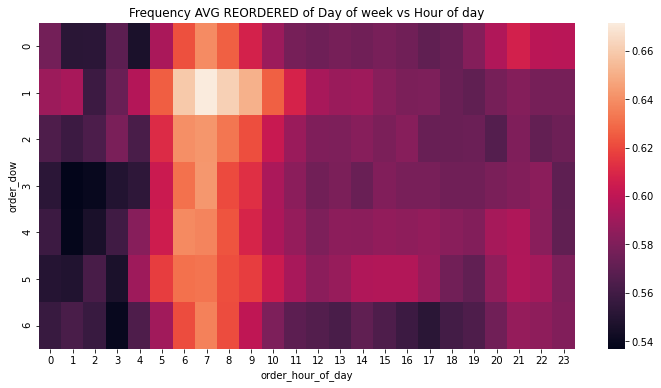

In [224]:
# merge customer past orders (order_prod_prior) & order in-depth details (orders)
orderprodprior_orders = pd.merge(order_prod_prior, orders, on='order_id', how='left')

# group data by order_dow, order_hour_of_day, and get average of reordered
grouped_df = orderprodprior_orders.groupby(['order_dow', 'order_hour_of_day'])['reordered'].aggregate('mean').reset_index()
grouped_df.head(3)
display(grouped_df)
grouped= grouped_df
# turn it to heatmap-suited format, by pivot it
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')
grouped_df.head(3)

# display result in heatmap 
plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency AVG REORDERED of Day of week vs Hour of day")
plt.show()


# highest on Sunday between 6am to 9am (nice)
# in general, for any days, highest between 5am to 9am
# interpretation : 0.66 means, 66% of all orders are actually reorders (returning customers)

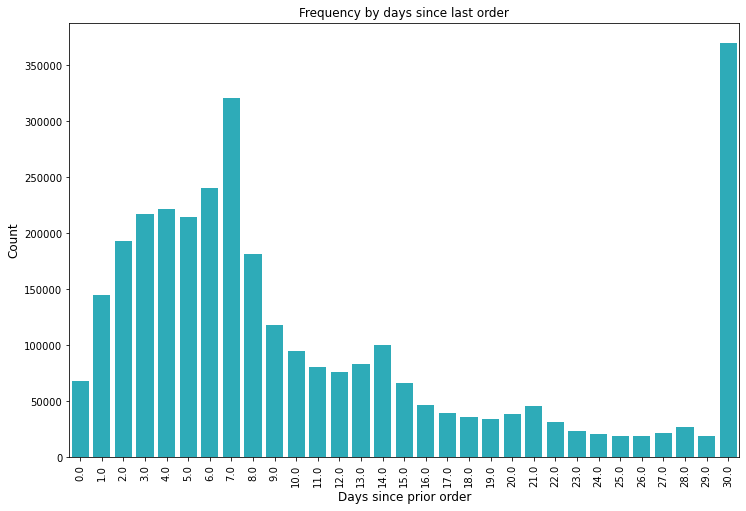

In [225]:
# Days since prior order column given
plt.figure(figsize=(12,8))
sns.countplot(x='days_since_prior_order', data=orders, color=color[9])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency by days since last order")
plt.show()

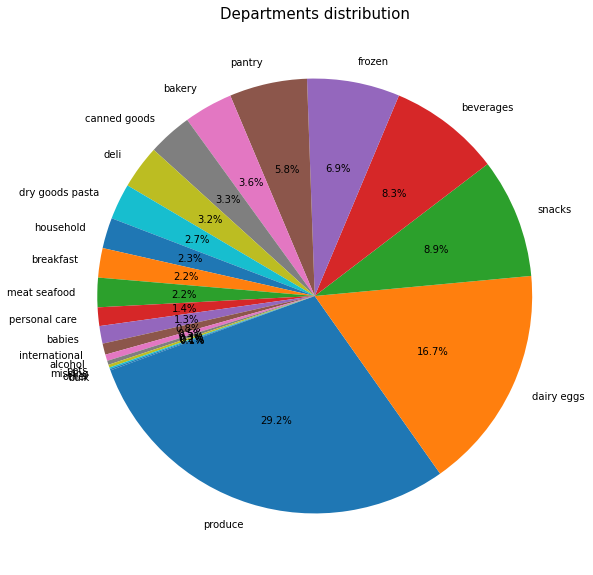

produce            0.292260
dairy eggs         0.166922
snacks             0.089027
beverages          0.082940
frozen             0.068952
pantry             0.057827
bakery             0.036282
canned goods       0.032930
deli               0.032411
dry goods pasta    0.026719
household          0.022774
breakfast          0.021877
meat seafood       0.021857
personal care      0.013785
babies             0.013066
international      0.008301
alcohol            0.004739
pets               0.003013
missing            0.002132
other              0.001119
bulk               0.001066
Name: department, dtype: float64

In [226]:
# department에 따른 비율
plt.figure(figsize=(10,10))
temp_series = all_join['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()
temp_series['Percentage']= temp_series/sum(temp_series)
temp_series['Percentage']

## Analysis

### Manipulate Train, Test data

In [270]:
data.isnull().sum()

user_id                                  0
product_id                               0
Times_Bought_N                           0
total_orders                             0
uxp_reorder_ratio                        0
u_reordered                              0
product_total_purchases                  0
p_reorder_ratio                          0
order_size_avg                           0
one_shot_pur                             0
order_id                                 0
eval_set                                 0
order_dow                                0
order_hour_of_day                        0
days_since_prior_order                   0
aisle_id                                 0
department_id                            0
mean_position                            0
dept_reorder_rate                        0
aisle_reorder_rate                       0
avg_add_to_cart_pos                      0
dept_percentage                          0
uxp_mean_position                        0
dow_reorder

In [263]:
# fill nan
data['product_reordered_dow'] = data['product_reordered_dow'].fillna(data['product_reordered_dow'].mean())
data['prod_reordered_hod'] = data['prod_reordered_hod'].fillna(data['prod_reordered_hod'].mean())
data['prod_reordered_dpo'] = data['prod_reordered_dpo'].fillna(data['prod_reordered_dpo'].mean())


In [227]:
# 결과는 test 데이터의 75000개 
# 만든 data set: 480만개
display(orders[orders['eval_set']=='test'])
# train인 데이터들을 학습하여 test데이터 예측
# train 데이터 840만개 order_id로 group을 만들어 product_id 예측
orders[orders['eval_set']=='train']

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0
...,...,...,...,...,...,...,...
3420918,2728930,206202,test,23,2,17,6.0
3420929,350108,206204,test,5,4,14,14.0
3421001,1043943,206206,test,68,0,20,0.0
3421018,2821651,206207,test,17,2,13,14.0


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,train,11,4,8,14.0
25,1492625,2,train,15,1,11,30.0
49,2196797,5,train,5,0,11,6.0
74,525192,7,train,21,2,11,6.0
78,880375,8,train,4,1,14,10.0
...,...,...,...,...,...,...,...
3420838,2585586,206199,train,20,2,16,30.0
3420862,943915,206200,train,24,6,19,6.0
3420924,2371631,206203,train,6,4,19,30.0
3420933,1716008,206205,train,4,1,16,10.0


In [264]:
# Get train data and test data
train_data = data[data.eval_set == 'train']
test_data = data[data.eval_set=='test']

# 여기서 order_prod_train데이터를 사용해서 reordered 데이터를 product_id, order_id로 merge
train_data = train_data.merge(order_prod_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )

# reordered nan 값들은 0으로
train_data.loc[:, 'reordered'] = train_data.reordered.fillna(0)

# 쓸모를 다한 eval_set과 order_id 제거
train_data = train_data.drop(['order_id', 'eval_set'], axis = 1)
test_data = test_data.drop(['order_id', 'eval_set'], axis = 1)

# user_id와 product_id로 groupby 진행후 sort
train_data = train_data.set_index(['user_id', 'product_id']).sort_index()
test_data = test_data.set_index(['user_id', 'product_id']).sort_index()
train_data

Times_Bought_N  total_orders  uxp_reorder_ratio  \
user_id product_id                                                    
1       196                     10            10           1.000000   
        10258                    9            10           1.000000   
        10326                    1            10           0.166667   
        12427                   10            10           1.000000   
        13032                    3            10           0.333333   
...                            ...           ...                ...   
206209  43961                    3            13           0.300000   
        44325                    1            13           0.142857   
        48370                    1            13           0.333333   
        48697                    1            13           0.142857   
        48742                    2            13           0.285714   

                    u_reordered  product_total_purchases  p_reorder_ratio  \
user_id product_id                                                          
1       196            0.694915                    35791         0.776480   
        10258          0.694915                     1946         0.713772   
        10326          0.694915                     5526         0.652009   
        12427          0.694915                     6476         0.740735   
        13032          0.694915                     3751         0.657158   
...                         ...                      ...              ...   
206209  43961          0.472868                    55371         0.630583   
        44325          0.472868                     3485         0.401148   
        48370          0.472868                     3934         0.699288   
        48697          0.472868                     9783         0.357661   
        48742          0.472868                     1723         0.498549   

                    order_size_avg  one_shot_pur  order_dow  \
user_id product_id                                            
1       196               5.900000      0.417500          4   
        10258             5.900000      6.225000          4   
        10326             5.900000      4.017467          4   
        12427             5.900000      8.681319          4   
        13032             5.900000     10.790323          4   
...                            ...           ...        ...   
206209  43961             9.923077     84.854701          6   
        44325             9.923077    741.000000          6   
        48370             9.923077     24.100000          6   
        48697             9.923077    185.840000          6   
        48742             9.923077     55.400000          6   

                    order_hour_of_day  ...  product_dow_reordered  isorganic  \
user_id product_id                     ...                                     
1       196                         8  ...               0.151092        1.0   
        10258                       8  ...               0.140389        0.0   
        10326                       8  ...               0.119067        0.0   
        12427                       8  ...               0.131957        0.0   
        13032                       8  ...               0.153753        0.0   
...                               ...  ...                    ...        ...   
206209  43961                      14  ...               0.139420        0.0   
        44325                      14  ...               0.144492        0.0   
        48370                      14  ...               0.130498        0.0   
        48697                      14  ...               0.147471        0.0   
        48742                      14  ...               0.138533        0.0   

                    ischocolate  ischicken  isyogurt  ismilk  isrice  \
user_id product_id                                                     
1       196                 0.0        0.0       0.0     0.0     0.0   
        10258    

## Check Top features (corr>10%)

In [252]:
train_data.columns

Index(['Times_Bought_N', 'total_orders', 'uxp_reorder_ratio', 'u_reordered',
       'product_total_purchases', 'p_reorder_ratio', 'order_size_avg',
       'one_shot_pur', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'aisle_id', 'department_id', 'mean_position',
       'dept_reorder_rate', 'aisle_reorder_rate', 'avg_add_to_cart_pos',
       'dept_percentage', 'uxp_mean_position', 'dow_reordered',
       'dow_aisle_rordered', 'dow_dept_rordered', 'dow_hour_reorder',
       'product_reordered_dow', 'prod_reordered_hod', 'prod_reordered_dpo',
       'day_reorder_rate', 'hour_reorder_rate',
       'p_days_since_prior_order_reorder_rate', 'hod_user_reordered',
       'dow_user_reordered', 'hod_product_reordered', 'product_dow_reordered',
       'isorganic', 'ischocolate', 'ischicken', 'isyogurt', 'ismilk', 'isrice',
       'iscoffee', 'isfruit', 'reordered'],
      dtype='object')

Index(['Times_Bought_N', 'uxp_reorder_ratio', 'product_total_purchases',
       'p_reorder_ratio', 'mean_position', 'dept_reorder_rate',
       'aisle_reorder_rate', 'dow_aisle_rordered', 'dow_dept_rordered',
       'product_reordered_dow', 'prod_reordered_hod', 'reordered'],
      dtype='object')


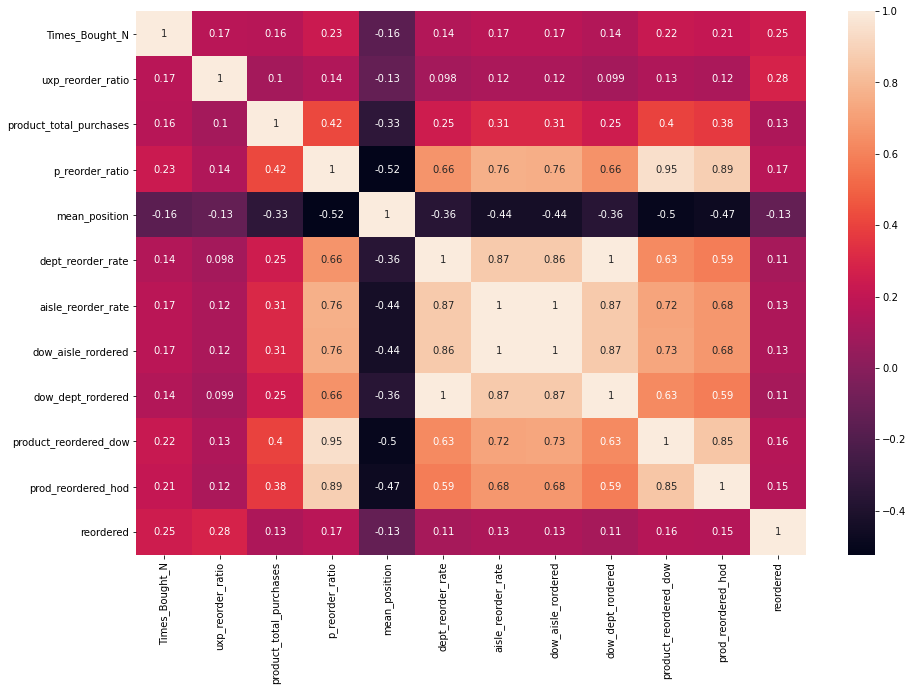

,Feature 1,Feature 2,Correlation Coefficient
44,reordered,reordered,1.000000
164,reordered,uxp_reorder_ratio,0.281597
173,reordered,Times_Bought_N,0.248379
227,reordered,p_reorder_ratio,0.167361
244,reordered,product_reordered_dow,0.159732
253,reordered,prod_reordered_hod,0.149647
285,reordered,aisle_reorder_rate,0.130655
286,reordered,dow_aisle_rordered,0.130308
291,reordered,mean_position,0.129359
298,reordered,product_total_purchases,0.126971


In [253]:
# 상관계수가 10% 이상인 종목만
cor = train_data.corr()
top_feature = cor.index[abs(cor['reordered']) >= 0.1]
print(top_feature)
top_corr = train_data[top_feature].corr()
plt.figure(figsize=(15,10))
sns.heatmap(top_corr, annot=True)
plt.xticks(rotation=90)
plt.show()

# corelation 확인
df_all_corr = train_data.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'reordered']

In [254]:
top_df = train_data[top_feature]
top_df

Times_Bought_N  uxp_reorder_ratio  \
user_id product_id                                      
1       196                     10           1.000000   
        10258                    9           1.000000   
        10326                    1           0.166667   
        12427                   10           1.000000   
        13032                    3           0.333333   
...                            ...                ...   
206209  43961                    3           0.300000   
        44325                    1           0.142857   
        48370                    1           0.333333   
        48697                    1           0.142857   
        48742                    2           0.285714   

                    product_total_purchases  p_reorder_ratio  mean_position  \
user_id product_id                                                            
1       196                           35791         0.776480       3.721774   
        10258                          1946         0.713772       4.277492   
        10326                          5526         0.652009       4.191097   
        12427                          6476         0.740735       4.760037   
        13032                          3751         0.657158       5.622767   
...                                     ...              ...            ...   
206209  43961                         55371         0.630583       9.194723   
        44325                          3485         0.401148      10.109900   
        48370                          3934         0.699288       8.344942   
        48697                          9783         0.357661       8.763058   
        48742                          1723         0.498549       7.991294   

                    dept_reorder_rate  aisle_reorder_rate  dow_aisle_rordered  \
user_id product_id                                                              
1       196                  0.653460            0.638832            0.632788   
        10258                0.574180            0.519170            0.523088   
        10326                0.649913            0.718104            0.720980   
        12427                0.574180            0.591986            0.583476   
        13032                0.560922            0.571584            0.569748   
...                               ...                 ...                 ...   
206209  43961                0.649913            0.638514            0.633045   
        44325                0.461076            0.453062            0.451338   
        48370                0.402178            0.528005            0.523536   
        48697                0.346721            0.350843            0.334800   
        48742                0.560922            0.499501            0.490805   

                    dow_dept_rordered  product_reordered_dow  \
user_id product_id                                             
1       196                  0.650271               0.768907   
        10258                0.565148               0.727612   
        10326                0.656404               0.626277   
        12427                0.565148               0.750890   
        13032                0.558289               0.699262   
...                               ...                    ...   
206209  43961                0.638100               0.630325   
        44325                0.458515               0.383302   
        48370                0.395386               0.677358   
        48697                0.329019               0.340819   
        48742                0.548609               0.500000   

                    prod_reordered_hod  reordered  
user_id product_id                                 
1       196                   0.800937        1.0  
        10258                 0.719008        1.0  
        10326                 0.675676        0.0  
        12427                 0.808511        0.0  
        13032                 0.675325        1.0  

## 실험
### 1. 모든 feature 사용
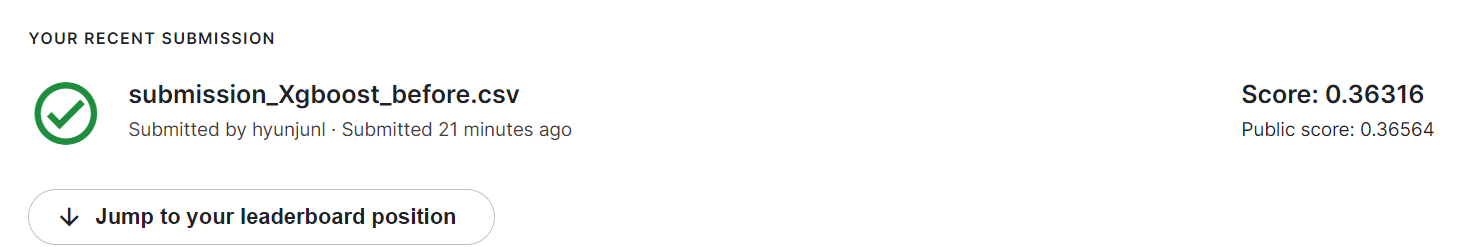


### 2. feature들을 줄였으나 결과가 0.36에서 0.35로 감소
feature selection xgboost 'uxp_reorder_ratio'는 corr, catboost에서 엄청 높게 나옴 그래서 삭제 x
- Delete
<br>
'total_orders', 'aisle_id', 'order_hour_of_day', 'dow_dept_reordered', 'uxp_mean_position', 'aisle_reoreder_rate', 'days_since_prior_order', 'order_dow', 'dow_reordered', 'dept_percentage', 'department_id', 'dept_reoreder_rate' ,'Times_Bought_N', 'isorganic', 'ischocolate', 'ischicken', 'iscoffee', 'isfruit', 'isyougurt', 'isrice', 'ismilk'

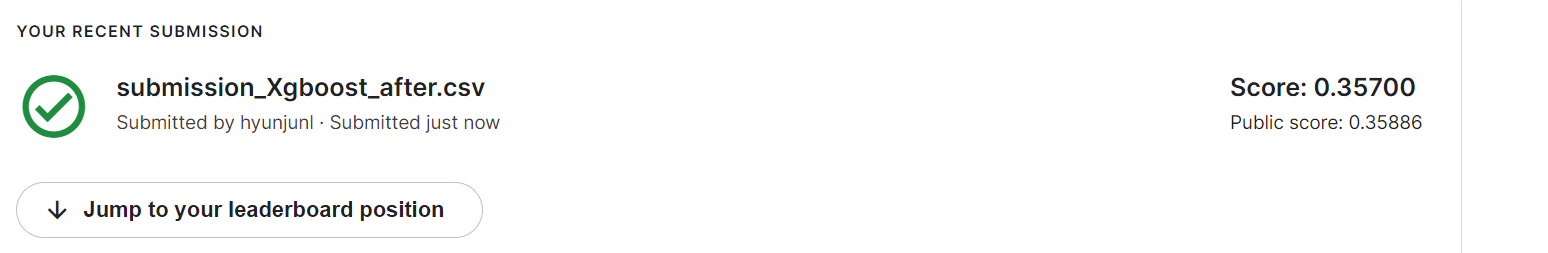

### 3. 그러나 feature들중 'isorganic', 'ischocolate', 'ischicken', 'iscoffee', 'isfruit', 'isyougurt', 'isrice', 'ismilk' 줄이니 score 향상
- feature들중 정말 낮은 feature들 제거하니 점수 증가

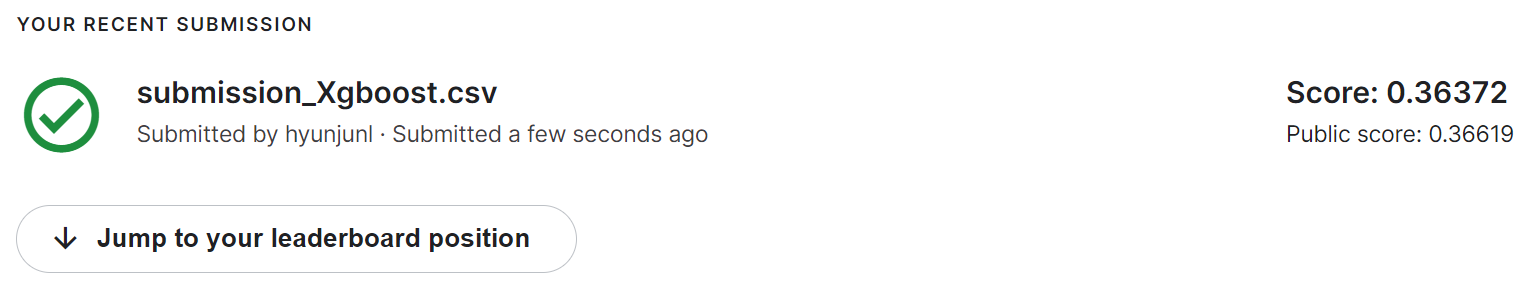

In [293]:
data_1 = data.copy()
data_1.columns
data_1 = data_1.drop([ 'isorganic', 'ischocolate', 'ischicken', 'iscoffee', 'isfruit', 'isyogurt', 'isrice', 'ismilk'], axis = 1)  #'total_orders', 'aisle_id', 'order_hour_of_day', 'uxp_mean_position', 'days_since_prior_order', 'order_dow', 'dow_reordered', 'dept_percentage', 'department_id', 'dept_reorder_rate' ,'Times_Bought_N',
train_data = data_1[data_1.eval_set == 'train']
test_data = data_1[data_1.eval_set=='test']
# train data에 y 변수인 reordered 추가
train_data = train_data.merge(order_prod_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
# 여기서 order_prod_train데이터를 사용해서 reordered 데이터를 product_id, order_id로 merge
# train_data = train_data.merge(order_prod_train[['product_id','order_id', 'reordered', 'add_to_cart_order']], on=['product_id','order_id'], how='left' )
train_data = train_data.fillna(0)
# drop the unused order_id
train_data = train_data.drop(['order_id', 'eval_set'], axis = 1)
test_data = test_data.drop(['order_id', 'eval_set'], axis = 1)

train_data = train_data.set_index(['user_id', 'product_id']).sort_index()
test_data = test_data.set_index(['user_id', 'product_id']).sort_index()

train_data

Times_Bought_N  total_orders  uxp_reorder_ratio  \
user_id product_id                                                    
1       196                     10            10           1.000000   
        10258                    9            10           1.000000   
        10326                    1            10           0.166667   
        12427                   10            10           1.000000   
        13032                    3            10           0.333333   
...                            ...           ...                ...   
206209  43961                    3            13           0.300000   
        44325                    1            13           0.142857   
        48370                    1            13           0.333333   
        48697                    1            13           0.142857   
        48742                    2            13           0.285714   

                    u_reordered  product_total_purchases  p_reorder_ratio  \
user_id product_id                                                          
1       196            0.694915                    35791         0.776480   
        10258          0.694915                     1946         0.713772   
        10326          0.694915                     5526         0.652009   
        12427          0.694915                     6476         0.740735   
        13032          0.694915                     3751         0.657158   
...                         ...                      ...              ...   
206209  43961          0.472868                    55371         0.630583   
        44325          0.472868                     3485         0.401148   
        48370          0.472868                     3934         0.699288   
        48697          0.472868                     9783         0.357661   
        48742          0.472868                     1723         0.498549   

                    order_size_avg  one_shot_pur  order_dow  \
user_id product_id                                            
1       196               5.900000      0.417500          4   
        10258             5.900000      6.225000          4   
        10326             5.900000      4.017467          4   
        12427             5.900000      8.681319          4   
        13032             5.900000     10.790323          4   
...                            ...           ...        ...   
206209  43961             9.923077     84.854701          6   
        44325             9.923077    741.000000          6   
        48370             9.923077     24.100000          6   
        48697             9.923077    185.840000          6   
        48742             9.923077     55.400000          6   

                    order_hour_of_day  ...  prod_reordered_hod  \
user_id product_id                     ...                       
1       196                         8  ...            0.800937   
        10258                       8  ...            0.719008   
        10326                       8  ...            0.675676   
        12427                       8  ...            0.808511   
        13032                       8  ...            0.675325   
...                               ...  ...                 ...   
206209  43961                      14  ...            0.624653   
        44325                      14  ...            0.370107   
        48370                      14  ...            0.730159   
        48697                      14  ...            0.331677   
        48742                      14  ...            0.475806   

                    prod_reordered_dpo  day_reorder_rate  hour_reorder_rate  \
user_id product_id                                                            
1       196                   0.038725          0.152580           0.059652   
        10258                 0.041110          0.137718           0.062179   
        10326                 0.035831          0.123959           0.066956   
        12427       

## Divide Train & Validation dataset
- 80% for Training
- 20% for Validation

In [294]:
# TRAIN FULL 

###########################
## IMPORT REQUIRED PACKAGES
###########################
import xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

########################################
## SPLIT DF TO: X_train, y_train (axis=1)
########################################
X_train, X_val, y_train, y_val = train_test_split(train_data.drop('reordered', axis=1), train_data.reordered,
                                                    test_size=0.2, random_state=42)

## Xgboost

In [295]:
import xgboost as xgb
from datetime import datetime
from sklearn.metrics import log_loss

def train_xgb(X_train, X_test, y_train, y_test, plot_importance = True, save = True, file_name = None, params = None):
    
    """
    Returns trained XGB model and output probabilities of validation set
    
    Parameters
    ----------
    X_train              : X_train data is passed 
    X_test               : X_test data is passed
    y_train              : y_train data is passed
    y_test               : y_test data is passed
    plot_importance      : The default is True
                          Boolean variable , Set to True if feature Importance
                          needs to be plotted
    save                 : The default is True
                          Boolean variable , Set to True if trained model 
                          needs to be saved
    file_name            : The default is None
                          Filename to be used while saving model
    params               : The default is None
                          dict of parameter set used to train XGBoost model
    Returns
    -------
    xgb_model            :  Trained XGBoost Model
    predict_y            : output probabilities for validation data
    """

    #defining set of parameters, these are optimal parameters obatined after 
    # rigorous hyperparameter Tuning
    if params is None:
        params = {}
        params['objective'] = 'binary:logistic'
        params['eval_metric'] = ['logloss']
        params['eta'] = 0.02
        params['max_depth'] = 15
        params['nthread']=-1
        params['colsample_bytree'] = 0.4
        params['tree_method'] = 'gpu_hist'
        
    #Create DataMatrix for XGBoost
    d_train = xgb.DMatrix(X_train, label=y_train)
    d_test = xgb.DMatrix(X_val, label=y_val)

    watchlist = [(d_train, 'train'), (d_test, 'valid')]
    
    #output Training Time
    start_time = datetime.now()
    print("Training Started :")
    xgb_model = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=20, verbose_eval=10)
    print("Training Completed ")
    end_time = datetime.now()
    difference = end_time - start_time
    time = divmod(difference.total_seconds() , 360)
    print("Total Time : {} minutes {} seconds".format(time[0], time[1]))
    
    #get probabilities for validation set
    predict_y = xgb_model.predict(d_test)
    print("The test log loss is:", log_loss(y_val, predict_y, labels=[0,1], eps=1e-15))
    
    #save trained model
    try:
        if save:
            file_name = "xgb_v1.pkl"

            # save
            pickle.dump(bst, open(file_name, "wb"))
    except Exception:
        pass
    #plot Feature Importance
    if plot_importance:
        print("Feature Importance")
        fig, ax = plt.subplots(1,1,figsize=(10,10))
        xgb.plot_importance(booster = xgb_model, ax = ax)

    return xgb_model, predict_y

Training Started :
[0]	train-logloss:0.68004	valid-logloss:0.68014
[10]	train-logloss:0.56727	valid-logloss:0.56867
[20]	train-logloss:0.48745	valid-logloss:0.49027
[30]	train-logloss:0.42774	valid-logloss:0.43188
[40]	train-logloss:0.38350	valid-logloss:0.38907
[50]	train-logloss:0.35052	valid-logloss:0.35741
[60]	train-logloss:0.32448	valid-logloss:0.33279
[70]	train-logloss:0.30480	valid-logloss:0.31453
[80]	train-logloss:0.28928	valid-logloss:0.30047
[90]	train-logloss:0.27658	valid-logloss:0.28931
[100]	train-logloss:0.26633	valid-logloss:0.28055
[110]	train-logloss:0.25858	valid-logloss:0.27428
[120]	train-logloss:0.25186	valid-logloss:0.26911
[130]	train-logloss:0.24699	valid-logloss:0.26567
[140]	train-logloss:0.24211	valid-logloss:0.26231
[150]	train-logloss:0.23806	valid-logloss:0.25987
[160]	train-logloss:0.23502	valid-logloss:0.25822
[170]	train-logloss:0.23174	valid-logloss:0.25639
[180]	train-logloss:0.22931	valid-logloss:0.25535
[190]	train-logloss:0.22685	valid-logloss:

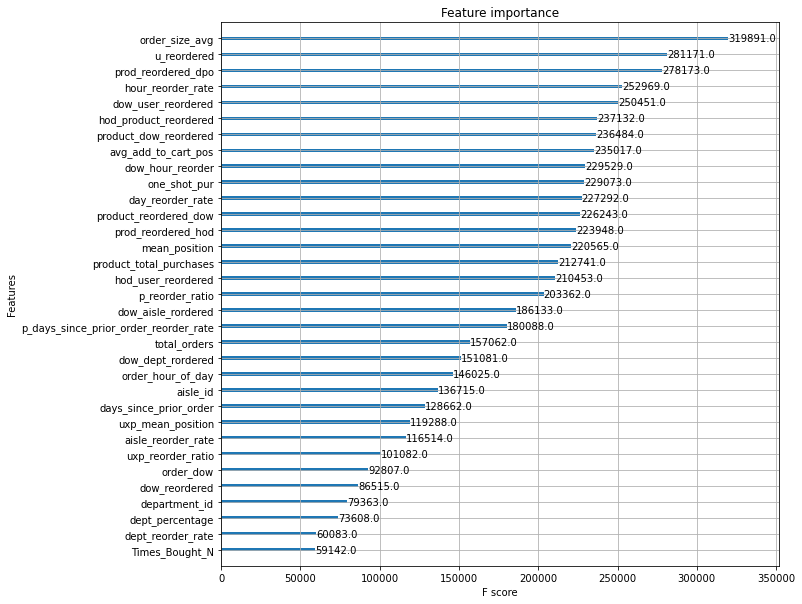

In [296]:
xgb_model = train_xgb(X_train, X_val, y_train, y_val)

## LogisticRegression

In [302]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42, n_jobs = -1)
log_reg.fit(X_train, y_train)

predict_lgr = log_reg.predict_proba(X_val)
print("logloss on validation data :",log_loss(y_val, predict_lgr, labels=[0,1], eps=1e-15))
y_test_pred_lgr = (log_reg.predict(X_val)>0.1).astype(int)


logloss on validation data : 0.3058982310392614


In [303]:
print('LogisticRegression model accuracy score: {0:0.4f}'. format(accuracy_score(y_val, y_test_pred_lgr)))
print('LogisticRegression model precision_score score: {0:0.4f}'. format(precision_score(y_val, y_test_pred_lgr)))
print('LogisticRegression model F1:',f1_score(y_val, y_test_pred_lgr))

LogisticRegression model accuracy score: 0.9020
LogisticRegression model precision_score score: 0.4807
LogisticRegression model F1: 0.021378973220332994


## Catboost

In [299]:
from catboost import CatBoostClassifier

def train_catboost(X_train, X_test, y_train, y_test, plot_importance = True, save = True, file_name = None):
    
    """
    Returns trained catboost model and output probabilities of validation set
    
    Parameters
    ----------
    X_train              : X_train data is passed 
    X_test               : X_test data is passed
    y_train              : y_train data is passed
    y_test               : y_test data is passed
    plot_importance      : The default is True
                          Boolean variable , Set to True if feature Importance
                          needs to be plotted
    save                 : The default is True
                          Boolean variable , Set to True if trained model 
                          needs to be saved
    file_name            : The default is None
                          Filename to be used while saving model
    Returns
    -------
    xgb_model            :  Trained XGBoost Model
    predict_y            : output probabilities for validation data
    """


    start_time = datetime.now()
    print("Training Started :")

    #defining set of parameters, these are optimal parameters obatined after 
    # rigorous hyperparameter Tuning
    c_model = CatBoostClassifier(task_type = "GPU", verbose=False, depth = 13, iterations= 2000, learning_rate= 0.02, scale_pos_weight= 1.0)
    c_model.fit(X_train,y_train)
    print("Training Completed ")
    end_time = datetime.now()
    difference = end_time - start_time
    time = divmod(difference.total_seconds() , 3600)
#     print("Total Time : {} hours {} seconds".format(time[0], time[1]))
    
    #get output probabilities
    predict_y = c_model.predict_proba(X_test)
    print('prediction_y', predict_y)
    print("The Test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))
    
    #get probs for class 1
    predict_y = predict_y[:,-1]
    predict_y = (predict_y>0.1).astype(int)
    #save the model    
    try:
        if save:
            file_name = "cat_v1.pkl"

            # save
            pickle.dump(c_model, open(file_name, "wb"))
    except Exception:
        pass
    
    #plot feature importance
    if plot_importance:
        #ref: https://stackoverflow.com/a/65842279/11533069
        f_imp=pd.DataFrame({'features': X_train.columns.to_numpy(),'feature_importance': c_model.get_feature_importance()})
        f_imp.sort_values(by = 'feature_importance', ascending = False, inplace = True)

        print("Feature Importance")
        fig, ax = plt.subplots(1,1,figsize=(10,10))
        sns.barplot(x = f_imp['feature_importance'], y = f_imp['features'])
        plt.title('Feature Importance')
        plt.xlabel('Importance')
        plt.ylabel('Features')

    return c_model, predict_y

Training Started :
Training Completed 
prediction_y [[0.81243933 0.18756067]
 [0.98597687 0.01402313]
 [0.96631634 0.03368366]
 ...
 [0.9135599  0.0864401 ]
 [0.98010563 0.01989437]
 [0.97256701 0.02743299]]
The Test log loss is: 0.24870561804896082
Feature Importance


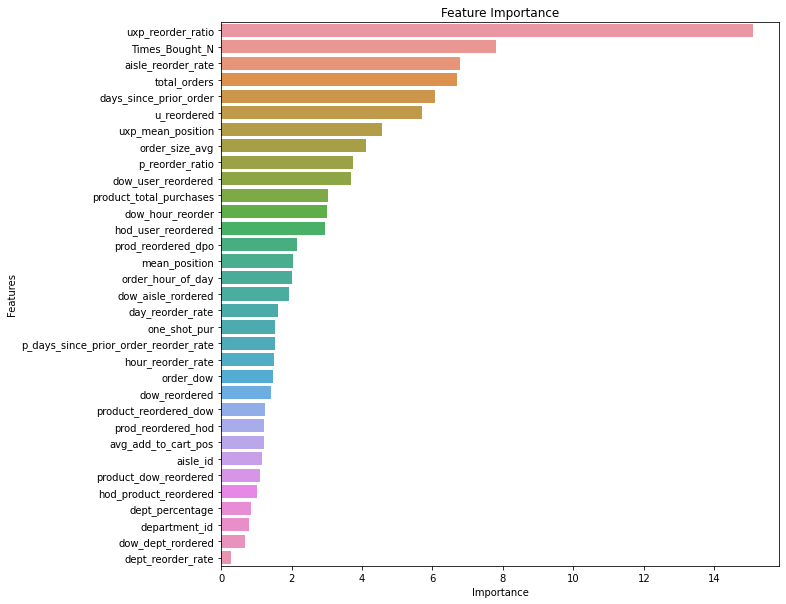

In [300]:
catboost_model = train_catboost(X_train, X_val, y_train, y_val)

## DecisionTreeClassifier

In [291]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

param_grid = {}
param_grid['max_depth'] = [5,10,15,20]
param_grid['min_samples_split'] = [2,3,4,5]

dt_clf = DecisionTreeClassifier()
r_search = RandomizedSearchCV(dt_clf, param_distributions=param_grid, cv = 5, verbose = True, n_jobs = -1)
r_search.fit(X_train, y_train)

predict_y = r_search.predict_proba(X_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


PicklingError: Could not pickle the task to send it to the workers.

In [ ]:
print("logloss on validation data :",log_loss(y_val, predict_y, labels=[0,1], eps=1e-15))
print('최적 하이퍼파라미터: ', r_search.best_params_)
y_test_pred = r_search.predict(X_val)
print('검증 정확도:', r_search.best_score_)
print('F1:',f1_score(y_val, y_test_pred, pos_label = 1))

### SVM

In [ ]:
# import sklearn.svm as svm

# from sklearn.model_selection import cross_val_score, cross_validate

# # SVM, kernel = 'linear'로 선형분리 진행
 
# svm_clf =svm.SVC(kernel = 'linear')

# # 교차검증

# scores = cross_val_score(svm_clf, X_train, y_train, cv = 5)
# scores

# pd.DataFrame(cross_validate(svm_clf, X, y, cv =5))

# print('교차검증 평균: ', scores.mean())


## Validation & Result

In [276]:
# TEST결과 생성 코드
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

def test_result(model_name, model, test_x, val_x, val_y):
    prediction = test_x.reset_index()
    prediction = prediction[['product_id', 'user_id']]
    
    result = 0.
    if model_name =='Xgboost':
        d_test = xgb.DMatrix(test_x)
        result = model.predict(d_test)
        prediction["reordered"] = (model.predict(d_test)> 0.2).astype(int)
    else:
        result = model.predict(test_x)
        prediction["reordered"] = (model.predict(test_x)> 0.2).astype(int)

    orders_val = orders[orders.eval_set=='test']
    prediction = prediction.merge(orders_val[["user_id", "order_id"]], on='user_id', how='left')

    prediction['product_id'] = prediction.product_id.astype(int)
    prediction = prediction.drop('user_id', axis=1)
    gc.collect()
    
    # validation
    if model_name =='Xgboost':
        d_val= xgb.DMatrix(val_x)
        val_prediction = (model.predict(d_val)> 0.2).astype(int)
    else:
        val_prediction = (model.predict(val_x)> 0.2).astype(int)

    print(model_name + ' model validation accuracy score: {0:0.4f}'. format(accuracy_score(val_y, val_prediction)))
    print(model_name + ' model validation precision_score score: {0:0.4f}'. format(precision_score(val_y, val_prediction)))
    print(model_name + ' model validation f1 score: {0:0.4f}'. format(f1_score(val_y, val_prediction)))
    
    d_val = dict()
    for row in prediction.itertuples():
        if row.reordered == 1:
            try:
                d_val[row.order_id] += ' ' + str(row.product_id)
            except:
                d_val[row.order_id] = str(row.product_id)

    for order in prediction.order_id:
        if order not in d_val:
            d_val[order] = 'None'
    #Convert the dictionary into a DataFrame
    sub_val = pd.DataFrame.from_dict(d_val, orient='index')

    #Reset index
    sub_val.reset_index(inplace=True)
    #Set column names
    sub_val.columns = ['order_id', 'products']
    gc.collect()
    sub_val.to_csv('submission_'+ model_name +'.csv', index=False)
    return prediction["reordered"]

### Xgboost Result

In [298]:
# Xgboost result
xgb_result = test_result('Xgboost', xgb_model[0], test_data, X_val, y_val)
xgb_result

Xgboost model validation accuracy score: 0.8706
Xgboost model validation precision_score score: 0.3793
Xgboost model validation f1 score: 0.4333


0          0
1          0
2          0
3          0
4          0
          ..
4833220    0
4833221    0
4833222    0
4833223    0
4833224    0
Name: reordered, Length: 4833225, dtype: int64

### Logistic Regression

In [278]:
log_reg_result = test_result('Logistic Regression', log_reg, test_data, X_val, y_val)
log_reg_result

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### Catboost Result

In [301]:
# Catbost result
catboost_result = test_result('catboost', catboost_model[0], test_data, X_val, y_val)
catboost_result

catboost model validation accuracy score: 0.9091
catboost model validation precision_score score: 0.6428
catboost model validation f1 score: 0.2582


0          0
1          0
2          0
3          0
4          0
          ..
4833220    0
4833221    0
4833222    0
4833223    0
4833224    0
Name: reordered, Length: 4833225, dtype: int64

### Random Forest Result

In [149]:
# Random Forest result
rf_result = test_result('random forest', r_search, test_data, X_val, y_val)
rf_result

NotFittedError: This RandomizedSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### Ensamble all the result
- When I tried the ensemble the result improved 
<br>
Score: 0.363 -> 0.36379
<br>
Public Score: 0.36455 -> 0.36571

In [304]:
prediction = test_data.reset_index()
prediction = prediction[['product_id', 'user_id']]
orders_val = orders[orders.eval_set=='test']
prediction = prediction.merge(orders_val[["user_id", "order_id"]], on='user_id', how='left')

prediction['product_id'] = prediction.product_id.astype(int)
prediction = prediction.drop('user_id', axis=1)
gc.collect()
ensemble_result = (xgb_result + catboost_result + log_reg_result)/3 #rf_result + |
print(ensemble_result.sum())
prediction['reordered'] = (ensemble_result> 0.).astype(int)
d_val = dict()
for row in prediction.itertuples():
    if row.reordered == 1:
        try:
            d_val[row.order_id] += ' ' + str(row.product_id)
        except:
            d_val[row.order_id] = str(row.product_id)

for order in prediction.order_id:
    if order not in d_val:
        d_val[order] = 'None'
#Convert the dictionary into a DataFrame
sub_val = pd.DataFrame.from_dict(d_val, orient='index')

#Reset index
sub_val.reset_index(inplace=True)
#Set column names
sub_val.columns = ['order_id', 'products']
gc.collect()
sub_val.to_csv('submission_ensemble.csv', index=False)
sub_val.head()

264120.9999999996


,order_id,products
0,2774568,9387 17668 18599 21903 22035 39190 43961 47766
1,1528013,21903 38293
2,1376945,8309 13176 14947 20383 24799 27959 28465 33572...
3,1356845,7076 10863 11520 13176 14992
4,2161313,196 10441 11266 12427 14715 27839 37710
